**Notebook Contents**
- [Imports](#Imports)
- [Data import](#Data-imports)
- [Data Cleaning](#Clean-Data)
- [Categorical Encoding](#Convert-ordinal-and-categorical-data-to-numeric)
- [EDA to predict missing values](#Exploratory-Data-Analysis)

# Imports

In [121]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score
from scipy.stats import stats
import statsmodels.api as sm


# plt.style.use('dark_background')
plt.style.use("default")

# Data imports

In [122]:
train = pd.read_csv("./datasets/train.csv")
kaggle = pd.read_csv("./datasets/test.csv")

In [123]:
print(f'The training data has {train.shape[0]} rows and {train.shape[1]} columns.')
print(f'The Kaggle data has {kaggle.shape[0]} rows and {kaggle.shape[1]} columns.')

The training data has 2051 rows and 81 columns.
The Kaggle data has 878 rows and 80 columns.


# Clean Data

### Converted all columns to lower case and separated by underscore

In [124]:
train.columns = train.columns.str.replace(" ", "_").str.lower()
kaggle.columns = kaggle.columns.str.replace(" ", "_").str.lower()

#### Renamed Id columns since it is needed for final kaggle submission

In [125]:
train.rename(columns={"id": "Id"}, inplace=True)
kaggle.rename(columns={"id": "Id"}, inplace=True)

##### Found lot of null values. After consulting the [data dictionary](./datasets/data_description.txt) , discovered that most of then are qualitative data , that should have been "NA". Some blanks in the quantitative data which should be 0 

In [126]:
train.isnull().sum()[train.isnull().sum() > 0].sort_values(ascending=False)

pool_qc           2042
misc_feature      1986
alley             1911
fence             1651
fireplace_qu      1000
lot_frontage       330
garage_yr_blt      114
garage_cond        114
garage_qual        114
garage_finish      114
garage_type        113
bsmt_exposure       58
bsmtfin_type_2      56
bsmt_cond           55
bsmt_qual           55
bsmtfin_type_1      55
mas_vnr_type        22
mas_vnr_area        22
bsmt_half_bath       2
bsmt_full_bath       2
garage_cars          1
bsmtfin_sf_1         1
bsmtfin_sf_2         1
bsmt_unf_sf          1
garage_area          1
total_bsmt_sf        1
dtype: int64

In [127]:
kaggle.isnull().sum()[kaggle.isnull().sum() > 0].sort_values(ascending=False)

pool_qc           874
misc_feature      837
alley             820
fence             706
fireplace_qu      422
lot_frontage      160
garage_yr_blt      45
garage_finish      45
garage_qual        45
garage_cond        45
garage_type        44
bsmtfin_type_2     25
bsmtfin_type_1     25
bsmt_exposure      25
bsmt_cond          25
bsmt_qual          25
mas_vnr_area        1
mas_vnr_type        1
electrical          1
dtype: int64

In [128]:
cols_replace_with_NA = ["pool_qc", "misc_feature", "alley", "fence", "fireplace_qu", "garage_qual", "garage_cond", "garage_finish", "garage_type", "bsmt_exposure", "bsmtfin_type_2", "bsmtfin_type_1", "bsmt_cond", "bsmt_qual", "mas_vnr_type", "electrical"]
cols_replace_with_0 = ["mas_vnr_area", "bsmt_half_bath", "bsmt_full_bath", "bsmt_unf_sf", "total_bsmt_sf", "bsmtfin_sf_2", "bsmtfin_sf_1", "garage_cars", "garage_area", "garage_yr_blt"]
train.loc[:, cols_replace_with_NA] = train.loc[:, cols_replace_with_NA].replace(np.nan,"NA")
train.loc[:, cols_replace_with_0] = train.loc[:, cols_replace_with_0].replace(np.nan,0)
kaggle.loc[:, cols_replace_with_NA] = kaggle.loc[:, cols_replace_with_NA].replace(np.nan,"NA")
kaggle.loc[:, cols_replace_with_0] = kaggle.loc[:, cols_replace_with_0].replace(np.nan,0)

##### Replaced all except for lot frontage. There are 330 missing values that are blank and at this point need to figure out what should be the value in the field. Cannot complete this step until the categorical data is transformed.

In [129]:
print(train.isnull().sum()[train.isnull().sum() > 0].sort_values(ascending=False))
print(kaggle.isnull().sum()[kaggle.isnull().sum() > 0].sort_values(ascending=False))

lot_frontage    330
dtype: int64
lot_frontage    160
dtype: int64


# Convert ordinal and categorical data to numeric

### Classification of features

In [130]:
nominal_cols = ["MS SubClass", "MS Zoning", "Street", "Alley", "Land Contour", "Lot Config", "Neighborhood","Condition 1","Condition 2","Bldg Type", "House Style", "Roof Style", "Roof Matl", "Exterior 1st", "Exterior 2nd", "Mas Vnr Type", "Foundation", "Heating", "Central Air", "Garage Type", "Misc Feature"]
ordinal_cols = ["Lot Shape", "Utilities", "Land Slope", "Overall Qual", "Overall Cond", "Exter Qual", "Exter Cond", "Bsmt Qual", "Bsmt Cond", "Bsmt Exposure", "BsmtFin Type 1", "BsmtFin Type 2", "Heating QC", "Electrical", "Kitchen Qual", "Functional", "Fireplace Qu", "Garage Finish", "Garage Qual", "Garage Cond", "Paved Drive", "Pool QC", "Fence"]
continuous_cols = ["Lot Frontage", "Lot Area", "Mas Vnr Area", "BsmtFin SF 1", "BsmtFin SF 2", "Bsmt Unf SF", "Total Bsmt SF", "1st Flr SF", "2nd Flr SF", "Low Qual Fin SF", "Gr Liv Area", "Garage Area", "Wood Deck SF", "Open Porch SF", "Enclosed Porch", "3Ssn Porch", "Screen Porch", "Pool Area", "Misc Val"]
discrete_cols = ["Year Built", "Year Remod/Add", "Bsmt Full Bath", "Bsmt Half Bath", "Full Bath", "Half Bath", "Bedroom abvgr", "Kitchen abvgr", "totrms abvgrd", "Fireplaces", "Garage Yr Blt", "Garage Cars", "Mo Sold" ,"Yr Sold"]

###### Converting the columns to match the headings from the training data set

In [131]:
def convert(x):
    return x.lower().replace(" ", "_")

nominal_con_cols = [convert(x) for x in nominal_cols]
ordinal_con_cols = {convert(x):{} for x in ordinal_cols}
continuous_con_cols = [convert(x) for x in continuous_cols]
discrete_con_cols = [convert(x) for x in discrete_cols]

##### Created a dictionay to convert a category to a numeric value

In [132]:
##Assigning numeric values to ordinal categories 
cat_replace_dict = {"REG": 4, "IR1" : 3 ,"IR2" : 2, "IR3": 1, 
 "ALLPUB": 4, "NOSEWR" : 3 ,"NOSEWA" : 2, "ELO": 1,
 "GTL": 3, "MOD" : 2 ,"SEV" : 1,
 "EX": 5, "GD" : 4 ,"TA" : 3, "FA" : 2, "PO": 1, "NA": 0, "NO" : 0,
 "GLQ": 6, "ALQ" : 5 ,"BLQ" : 4, "REC" : 3, "LWQ": 2, "UNF": 1, "NA" : 0,
 "SBRKR":5 , "FUSEA":4 , "FUSEF" :3 , "FUSEP":2 , "MIX": 1,
 "TYP": 8, "MIN1" :7 , "MIN2": 6, "MOD":5 , "MAJ1": 4, "MAJ2":3, "SEV": 2, "SAL": 1,
 "FIN": 3 , "RFN":2,
 "Y" : 3, "P": 2, "N": 1,
 "GDPRV":4 , "MNPRV":3 , "GDWO": 2, "MNWW":1,
 "AV": 3, "MN": 2}

def conver_to_numeric(series):
    return_list_x = []
    for x in series:
        try:
            x = x.upper()
            return_list_x.append(cat_replace_dict[x])
        except:
            return_list_x.append(x)
    return np.array(return_list_x)

In [133]:
train.loc[: , ordinal_con_cols] = train.loc[: , ordinal_con_cols].apply(conver_to_numeric)
kaggle.loc[: , ordinal_con_cols] = kaggle.loc[: , ordinal_con_cols].apply(conver_to_numeric)

###### Checking if everything got converted correctly to numerical values in both training as well as kaggle test set

In [134]:
print(train[ordinal_con_cols].dtypes)
print(kaggle[ordinal_con_cols].dtypes)

lot_shape         int64
utilities         int64
land_slope        int64
overall_qual      int64
overall_cond      int64
exter_qual        int64
exter_cond        int64
bsmt_qual         int64
bsmt_cond         int64
bsmt_exposure     int64
bsmtfin_type_1    int64
bsmtfin_type_2    int64
heating_qc        int64
electrical        int64
kitchen_qual      int64
functional        int64
fireplace_qu      int64
garage_finish     int64
garage_qual       int64
garage_cond       int64
paved_drive       int64
pool_qc           int64
fence             int64
dtype: object
lot_shape         int64
utilities         int64
land_slope        int64
overall_qual      int64
overall_cond      int64
exter_qual        int64
exter_cond        int64
bsmt_qual         int64
bsmt_cond         int64
bsmt_exposure     int64
bsmtfin_type_1    int64
bsmtfin_type_2    int64
heating_qc        int64
electrical        int64
kitchen_qual      int64
functional        int64
fireplace_qu      int64
garage_finish     int64
ga

#### Creating dummy variables for nominal columns

In [135]:
dummies_train = pd.DataFrame()
dummies_kaggle = pd.DataFrame()
for cols in nominal_con_cols:
    dummies_train = pd.concat((dummies_train,pd.get_dummies(train[cols], prefix="dum"+cols[:3])), axis=1)
    dummies_kaggle = pd.concat((dummies_kaggle,pd.get_dummies(kaggle[cols], prefix="dum"+cols[:3])), axis=1)

In [136]:
dummies_train.columns = dummies_train.columns.str.lower().str.replace(" ", "_")
dummies_kaggle.columns = dummies_kaggle.columns.str.lower().str.replace(" ", "_")

In [137]:
print("Training set : There are {} rows and {} cols in the dummy table".format(dummies_train.shape[0], dummies_train.shape[1]))
print("Kaggle   set : There are {} rows and {} cols in the dummy table".format(dummies_kaggle.shape[0], dummies_kaggle.shape[1]))

Training set : There are 2051 rows and 168 cols in the dummy table
Kaggle   set : There are 878 rows and 156 cols in the dummy table


#### Adding all the dummy columns to the main train data set

In [138]:
train = pd.concat((train, dummies_train), axis=1)
kaggle = pd.concat((kaggle, dummies_kaggle), axis=1)

In [139]:
print(train.shape)
print(kaggle.shape)

(2051, 249)
(878, 236)


In [140]:
train.filter(regex="dum").dtypes.unique()

array([dtype('uint8')], dtype=object)

In [141]:
kaggle.filter(regex="dum").dtypes.unique()

array([dtype('uint8')], dtype=object)

#### Next step is to create bin range to the discrete columns 

In [142]:
train["bin_year_built"] = train["year_built"] // 100 * 100
train["bin_year_remod/add"] = train["year_remod/add"] // 100 * 100
train["bin_total_baths"] = train["bsmt_full_bath"] + (train["bsmt_half_bath"] * 0.5) + train["full_bath"] + (train["half_bath"] * 0.5)
train["bin_garage_yr_blt"] = train["garage_yr_blt"] // 100 * 100
train["bin_garage_yr_blt"] = train["bin_garage_yr_blt"].astype(int)

In [143]:
kaggle["bin_year_built"] = kaggle["year_built"] // 100 * 100
kaggle["bin_year_remod/add"] = kaggle["year_remod/add"] // 100 * 100
kaggle["bin_total_baths"] = kaggle["bsmt_full_bath"] + (kaggle["bsmt_half_bath"] * 0.5) + kaggle["full_bath"] + (kaggle["half_bath"] * 0.5)
kaggle["bin_garage_yr_blt"] = kaggle["garage_yr_blt"] // 100 * 100
kaggle["bin_garage_yr_blt"] = kaggle["bin_garage_yr_blt"].astype(int)

##### One of the data point had "garage built year"  as 2200 so changed that to match the year built of the house

In [144]:
train.loc[1699, "bin_garage_yr_blt"] = 2000

# Exploratory Data Analysis

There are more than 300 missing values in lot_frontage . So checking if it can be predicted using other values.

###### 3 ways of correcting 
     -- Putting 0 if the value is unknown
     -- Put the median from the known values
     -- Use features with high correlation to predict the unknown

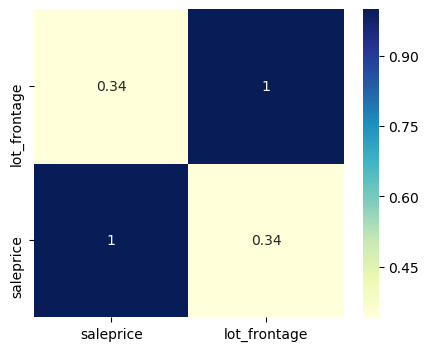

In [145]:
plt.figure(figsize=(5,4))
sns.heatmap(train.loc[:, ["saleprice", "lot_frontage"]].corr(),  cmap="YlGnBu", annot=True);
plt.ylim(0, 2);

Is lot frontage tatistically significant to predict sale price. Let us look at the p value for that

In [146]:
mask = -train["lot_frontage"].isnull()
y = train.loc[mask, 'saleprice']
ols_X = sm.add_constant(train.loc[mask, ["lot_frontage"]])
model_ols = sm.OLS(y,ols_X).fit()
model_ols.summary().tables[1]

/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


,coef,std err,t,P>|t|,[0.025,0.975]
const,9.649e+04,5856.357,16.477,0.000,8.5e+04,1.08e+05
lot_frontage,1212.1451,80.372,15.082,0.000,1054.507,1369.783


In [147]:
train["lot_frontage_copy"] = train["lot_frontage"]
train.loc[train["lot_frontage_copy"].isnull(), ["lot_frontage_copy"]] = 0
train["lot_frontage_copy"].isnull().sum()

0

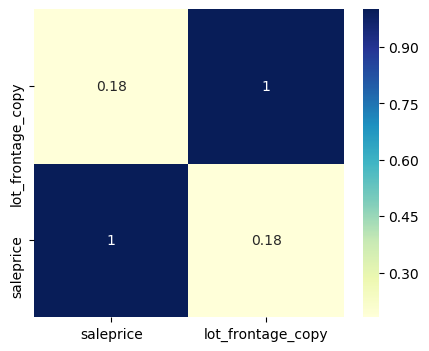

In [148]:
plt.figure(figsize=(5,4))
sns.heatmap(train.loc[:, ["saleprice", "lot_frontage_copy"]].corr(),  cmap="YlGnBu", annot=True);
plt.ylim(0, 2);

In [149]:
train["lot_frontage_copy"] = train["lot_frontage"]
train.loc[train["lot_frontage_copy"].isnull(), ["lot_frontage_copy"]] = train["lot_frontage_copy"].mean()
train["lot_frontage_copy"].isnull().sum()

0

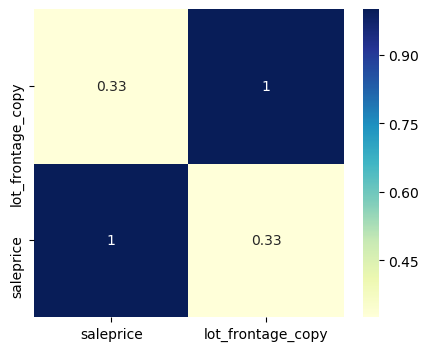

In [150]:
plt.figure(figsize=(5,4))
sns.heatmap(train.loc[:, ["saleprice", "lot_frontage_copy"]].corr(),  cmap="YlGnBu", annot=True);
plt.ylim(0, 2);

In [151]:
train.drop(columns="lot_frontage_copy", inplace=True)

In [152]:
#If I were to predict the value using mean value
# Create column called Mean_Yhat that is the mean of Y.
mask = -train["lot_frontage"].isnull()
train.loc[mask, 'Mean_lot_frontage_Yhat'] = train.loc[mask,"lot_frontage"].mean()
# Calculate MSE of the naive prediction.
rmse = mean_squared_error(train.loc[mask, 'lot_frontage'], train.loc[mask, 'Mean_lot_frontage_Yhat']) ** (1/2)
print("If we take the mean value for prediction, it will be {}".format(rmse))

If we take the mean value for prediction, it will be 23.253894551836126


In [153]:
train.corr()["lot_frontage"].sort_values(ascending=False)

lot_frontage      1.000000
lot_area          0.574024
1st_flr_sf        0.463900
dumbld_1fam       0.409691
gr_liv_area       0.383856
                    ...   
dumms__150             NaN
dumnei_grnhill         NaN
dumnei_landmrk         NaN
dumcon_rrae            NaN
dumcon_rran            NaN
Name: lot_frontage, Length: 233, dtype: float64

###### From the above correlation, it looks like lot_area can be used to best predict lot frontage

The above prediction can be plotted as follows:

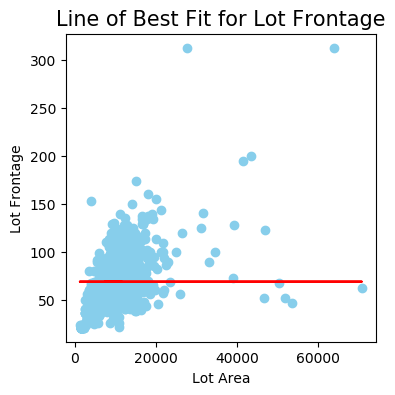

In [154]:
feature_lot_frontage = ["lot_area"]
y_hat = train.loc[mask, 'Mean_lot_frontage_Yhat']
y = train.loc[mask, 'lot_frontage']
X = train.loc[mask, feature_lot_frontage]

# Plot the model
plt.figure(figsize=(4,4))

# Generate a scatterplot of our data.
plt.scatter(X, y, color='skyblue')

# Also generate a line for our prediction.
plt.plot(X, y_hat, color='red')

    
# Create a title.
plt.title('Line of Best Fit for Lot Frontage', fontsize = 15);
plt.xlabel("Lot Area" , fontsize = 10)
plt.ylabel("Lot Frontage", fontsize = 10);

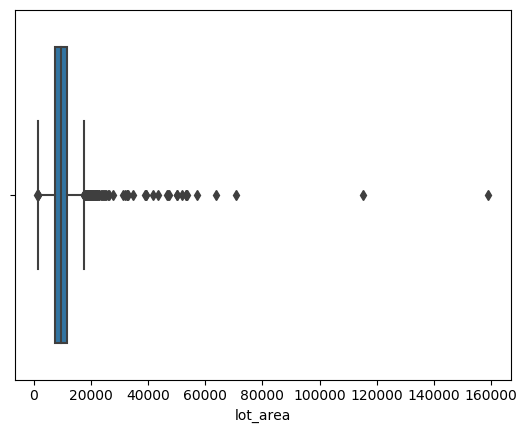

In [155]:
sns.boxplot(train["lot_area"]);

In [156]:
train[train["lot_area"] > 100_000]

,Id,pid,ms_subclass,ms_zoning,lot_frontage,lot_area,street,alley,lot_shape,land_contour,...,dummis_gar2,dummis_na,dummis_othr,dummis_shed,dummis_tenc,bin_year_built,bin_year_remod/add,bin_total_baths,bin_garage_yr_blt,Mean_lot_frontage_Yhat
471,2116,906426060,50,RL,NaN,159000,Pave,NA,2,Low,...,0,0,0,1,0,1900,2000,2.5,1900,NaN
694,2072,905301050,20,RL,NaN,115149,Pave,NA,2,Low,...,0,1,0,0,0,1900,2000,3.0,1900,NaN


In [157]:
train.loc[train["lot_area"] > 100_000, "lot_area"] = train["lot_area"].median()

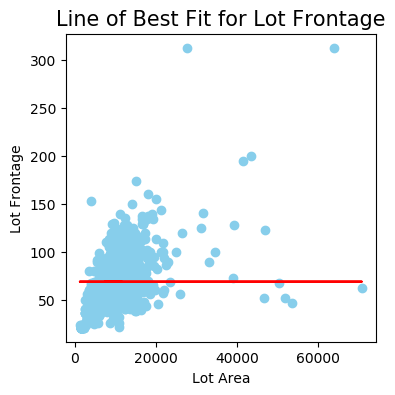

In [158]:
feature_lot_frontage = ["lot_area"]
y_hat = train.loc[mask, 'Mean_lot_frontage_Yhat']
y = train.loc[mask, 'lot_frontage']
X = train.loc[mask, feature_lot_frontage]

# Plot the model
plt.figure(figsize=(4,4))

# Generate a scatterplot of our data.
plt.scatter(X, y, color='skyblue')

# Also generate a line for our prediction.
plt.plot(X, y_hat, color='red')

    
# Create a title.
plt.title('Line of Best Fit for Lot Frontage', fontsize = 15);
plt.xlabel("Lot Area" , fontsize = 10)
plt.ylabel("Lot Frontage", fontsize = 10);

In [159]:
train.drop(columns="Mean_lot_frontage_Yhat", inplace=True)

In [160]:
train["lot_frontage"].describe()

count    1721.000000
mean       69.055200
std        23.260653
min        21.000000
25%        58.000000
50%        68.000000
75%        80.000000
max       313.000000
Name: lot_frontage, dtype: float64

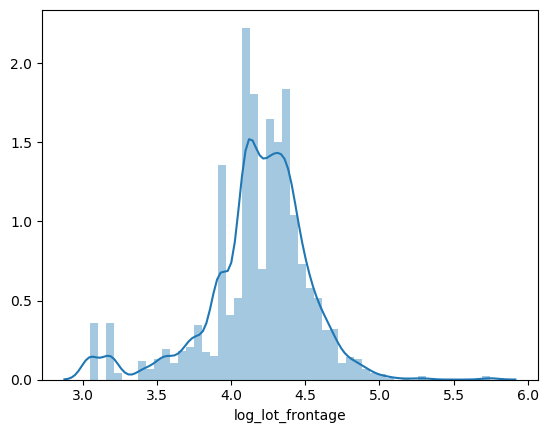

In [161]:
train["log_lot_frontage"] = train["lot_frontage"].map(np.log)
sns.distplot(train.loc[mask, "log_lot_frontage"]);

In [162]:
features_lot_frontage = ['lot_area',
 'dumlot_corner',
 'dumlot_fr3',
 'gr_liv_area',
 'dumnei_blueste',
 'dumnei_brdale',
 'dumnei_meadowv',
 'dumnei_mitchel',
 'dumnei_names',
 'dumnei_npkvill',
 'dumnei_nwames',
 'dumnei_noridge',
 'dumnei_nridght',
 'dumnei_sawyer',
 'dumnei_stonebr',
 'dumms__20',
 'dumms__30']

In [163]:
X = train.loc[mask, features_lot_frontage]
y = train.loc[mask, "log_lot_frontage"]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [164]:
train_preds = lr.predict(X_train)
test_preds = lr.predict(X_test)

train_preds_original = np.exp(train_preds)
test_preds_original = np.exp(test_preds)

y_train = np.exp(y_train)
y_test = np.exp(y_test)

In [165]:
train_rmse = mean_squared_error(y_train, train_preds_original) ** (1/2)
test_rmse = mean_squared_error(y_test, test_preds_original) ** (1/2)

print("Train RMSE : {}".format(train_rmse))
print("Test RMSE : {}".format(test_rmse))

Train RMSE : 17.478139720059605
Test RMSE : 14.035329824630153


In [166]:
train_r2 = r2_score(y_train, train_preds)
test_r2 = r2_score(y_test, test_preds)

print("Train R-squared: {}".format(train_r2))
print("Test R-squared: {}".format(test_r2))

Train R-squared: -7.241701375133978
Test R-squared: -9.920523443195846


In [167]:
cross_val_score(lr, X_train, y_train, cv=5).mean()

0.4794111895724926

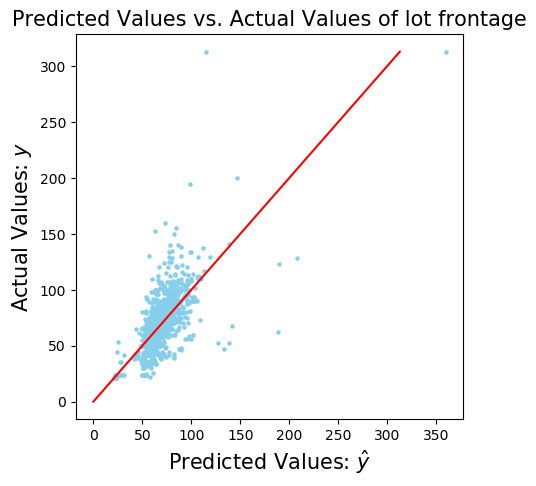

In [168]:
y_hat = train_preds_original
y = y_train


#Plotting the naive model 
plt.figure(figsize=(5,5))

# Generate a scatterplot of predicted values versus actual values.
plt.scatter(y_hat, y, s=5, color='skyblue', alpha = 1)

sns.lineplot([0, np.max(y)], [0, np.max(y)], color="red")

# Tweak title and axis labels.
plt.xlabel("Predicted Values: $\hat{y}$", fontsize = 15)
plt.ylabel("Actual Values: $y$", fontsize = 15)
plt.title('Predicted Values vs. Actual Values of lot frontage', fontsize = 15);

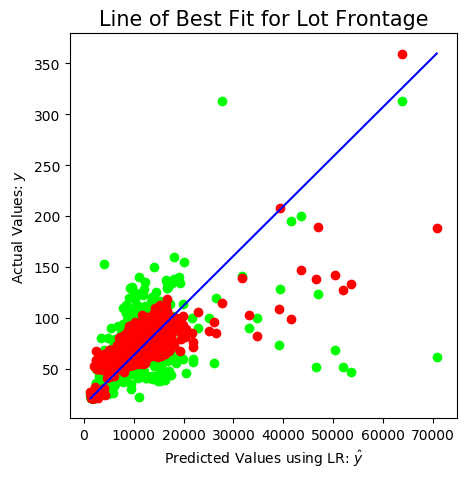

In [169]:
feature_lot_frontage = ["lot_area"]
y_hat = train_preds_original
y = y_train
X = X_train["lot_area"]

# Plot the model
plt.figure(figsize=(5,5))

# Generate a scatterplot of our data.
plt.scatter(X, y, color='lime')

# Also generate a line for our prediction.
plt.scatter(X, y_hat, color='red')
plt.plot([X.min(),X.max()] , [y_hat.min(),y_hat.max()], color='blue')

    
# Create a title.
plt.title('Line of Best Fit for Lot Frontage', fontsize = 15);
plt.xlabel("Predicted Values using LR: $\hat{y}$", fontsize = 10)
plt.ylabel("Actual Values: $y$", fontsize = 10);

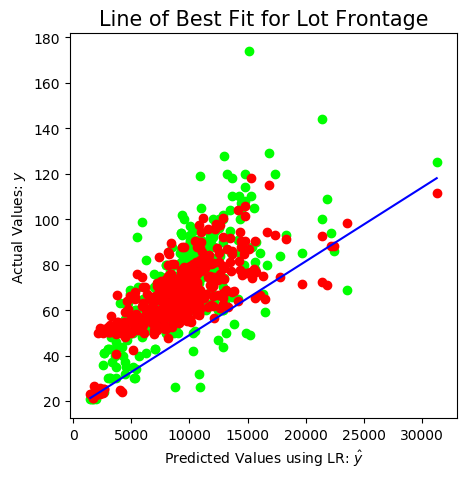

In [170]:
feature_lot_frontage = ["lot_area"]
y_hat = test_preds_original
y = y_test
X = X_test["lot_area"]

# Plot the model
plt.figure(figsize=(5,5))

# Generate a scatterplot of our data.
plt.scatter(X, y, color='lime')

# Also generate a line for our prediction.
plt.scatter(X, y_hat, color='red')
plt.plot([X.min(),X.max()] , [y_hat.min(),y_hat.max()], color='blue')

    
# Create a title.
plt.title('Line of Best Fit for Lot Frontage', fontsize = 15);
plt.xlabel("Predicted Values using LR: $\hat{y}$", fontsize = 10)
plt.ylabel("Actual Values: $y$", fontsize = 10);

In [171]:
train.at[train["lot_frontage"].isnull(), ["lot_frontage"]] = np.exp(lr.predict(train.loc[train["lot_frontage"].isnull(), features_lot_frontage]))

In [172]:
train.loc[train["lot_frontage"] > 313, "lot_frontage"] = 313
train["lot_frontage"].describe()

count    2051.000000
mean       69.664614
std        22.471579
min        21.000000
25%        59.022140
50%        68.636179
75%        80.000000
max       313.000000
Name: lot_frontage, dtype: float64

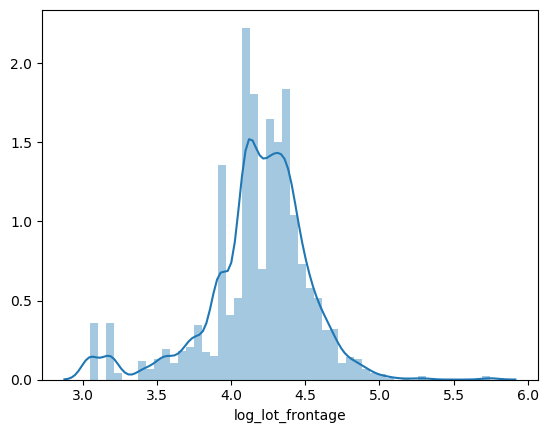

In [173]:
train["log_lot_frontage"] = train["lot_frontage"].map(np.log)
sns.distplot(train.loc[mask, "log_lot_frontage"]);

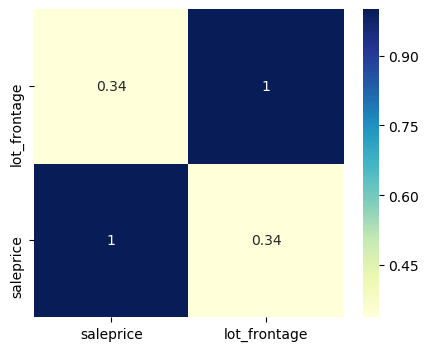

In [174]:
plt.figure(figsize=(5,4))
sns.heatmap(train.loc[:, ["saleprice", "lot_frontage"]].corr(),  cmap="YlGnBu", annot=True);
plt.ylim(0, 2);

#### Repeating the above to predict kaggle  lot_frontage

In [175]:
mask = -kaggle["lot_frontage"].isnull()
kaggle["lot_frontage"].describe()

count    718.000000
mean      69.545961
std       23.533945
min       21.000000
25%       59.000000
50%       68.000000
75%       80.000000
max      182.000000
Name: lot_frontage, dtype: float64

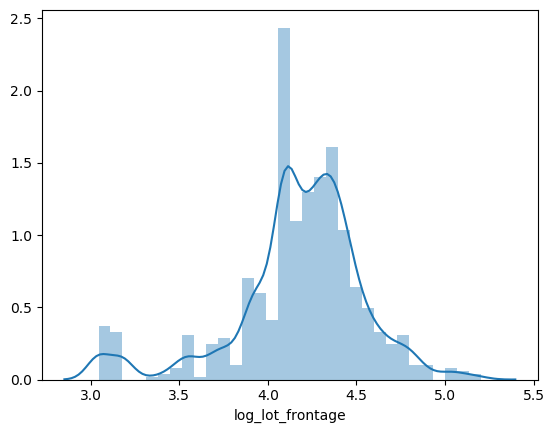

In [176]:
kaggle["log_lot_frontage"] = kaggle["lot_frontage"].map(np.log)
sns.distplot(kaggle.loc[mask, "log_lot_frontage"]);

In [177]:
##list of features that are null in the kaggle test data
X = kaggle.loc[mask, features_lot_frontage]

null_cols = list(X.isnull().sum()[X.isnull().sum() > 0].index)
for n in null_cols:
    features_lot_frontage.remove(n)
    
X = kaggle.loc[mask, features_lot_frontage]
y = kaggle.loc[mask, "log_lot_frontage"]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [178]:
train_preds = lr.predict(X_train)
test_preds = lr.predict(X_test)

train_preds_original = np.exp(train_preds)
test_preds_original = np.exp(test_preds)

y_train = np.exp(y_train)
y_test = np.exp(y_test)

In [179]:
train_rmse = mean_squared_error(y_train, train_preds_original) ** (1/2)
test_rmse = mean_squared_error(y_test, test_preds_original) ** (1/2)

print("Train RMSE : {}".format(train_rmse))
print("Test RMSE : {}".format(test_rmse))

Train RMSE : 17.107249456260643
Test RMSE : 20.87727290103584


In [180]:
cross_val_score(lr, X_train, y_train, cv=5).mean()

0.03724624018838785

In [181]:
kaggle.at[kaggle["lot_frontage"].isnull(), ["lot_frontage"]] = np.exp(lr.predict(kaggle.loc[kaggle["lot_frontage"].isnull(), features_lot_frontage]))

In [182]:
#CI after prediction..the values still remain close
kaggle["lot_frontage"].describe()

count    878.000000
mean      69.907236
std       22.543342
min       21.000000
25%       59.000000
50%       69.000000
75%       80.000000
max      207.939246
Name: lot_frontage, dtype: float64

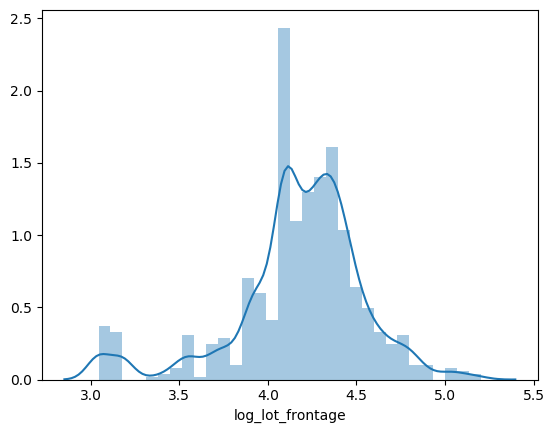

In [183]:
kaggle["log_lot_frontage"] = kaggle["lot_frontage"].map(np.log)
sns.distplot(kaggle.loc[mask, "log_lot_frontage"]);

In [184]:
print("No more null values remain in either data set")
print(train.isnull().sum()[train.isnull().sum() > 0].sort_values(ascending=False))
print(kaggle.isnull().sum()[kaggle.isnull().sum() > 0].sort_values(ascending=False))

No more null values remain in either data set
Series([], dtype: int64)
Series([], dtype: int64)


In [185]:
##Save both the cleaned train data and kaggle data for further analysis
train.to_csv("./interim_datasets/train_interim.csv")
kaggle.to_csv("./interim_datasets/kaggle_interim.csv")

####    NEXT  --- > [2. Exploratory Data Analysis](./2_Exploratory_Data_Analysis.ipynb)